In [1]:
import torch, torchvision
import detectron2

import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

In [2]:
### Default CONFIGS according to https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5 Colab Notebook
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
###

In [3]:
predictor = DefaultPredictor(cfg)  # this is the mask RCNN model 

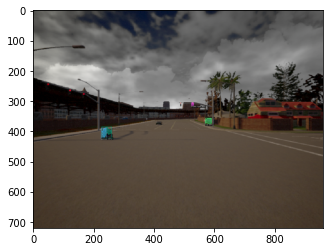

['traffic light', 'person', 'person', 'car']


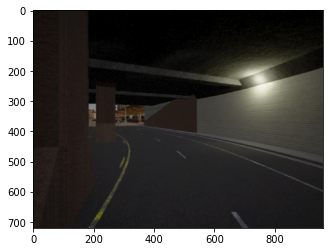

[]


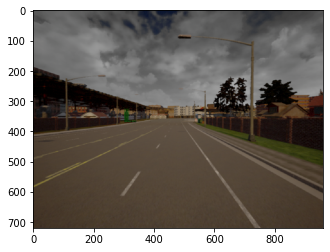

['person']


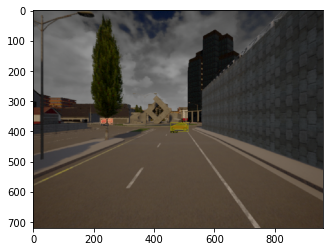

['car', 'car']


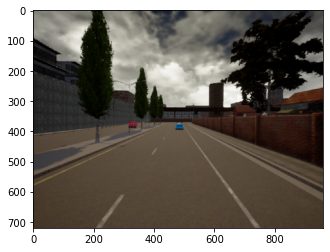

['car', 'car']


In [13]:
# First, let's try segmenting CARLA images without any finetuning
img_dir_path = "../../data/CARLA_OOD_Dataset/images/cloudy_evening_busy_val"
im_files = list(os.listdir(img_dir_path))


for im_file in random.sample(im_files, 5):
    img = cv2.imread(os.path.join(img_dir_path, im_file)) #cv2 reads images in BGR
    #plt.imshow(img[:,:,::-1]) #need to convert image from BGR to RGB for plt show. 
    
    #run it through model
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    #plt.figure(figsize=(400,400))
    plt.imshow(out.get_image()[:, :, :])
    
    plt.show()
    
    class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
    print([class_names[c] for c in outputs['instances'].pred_classes.cpu()])

In [9]:
## As we can see, it only recognizes car and person and sometimes traffic light. It misses trees, houses etc. 
## Let's fine-tune detectron on CARLA images
import pickle as pkl
import pycocotools
from detectron2.structures import BoxMode

## some helper functions
def get_mask(seg_im, rgb_value):
    # rgb_value should be somethiing like np.uint8([[[70, 70, 70]]])
    # seg_im should be in HSV
    
    hsv_value = cv2.cvtColor(rgb_value, cv2.COLOR_RGB2HSV)
    
    hsv_low = np.array([[[hsv_value[0][0][0]-5, hsv_value[0][0][1], hsv_value[0][0][2]-5]]])
    hsv_high = np.array([[[hsv_value[0][0][0]+5, hsv_value[0][0][1], hsv_value[0][0][2]+5]]])
    
    mask = cv2.inRange(seg_im, hsv_low, hsv_high)
    return mask

def get_bbox_from_mask(mask):
    label_mask = measure.label(mask)
    props = measure.regionprops(label_mask)
    
    return [prop.bbox for prop in props]
##

## required for meta data - optional
carla_ann = pkl.load(open("../../data/CARLA_maskrcnn_finetune/COCO_annotation.pkl", "wb"))
all_obj_categories = []
for entry in carla_ann:
    for obj_ann in entry['annotations']:
        all_obj_categories.append(obj_ann['obj_name'])

all_obj_categories = sorted(list(set(all_obj_categories))) # make a list of unique obj names.
##

## Prepare Dataset
def get_CARLA_dataset(split):
    
    carla_ann = pkl.load(open("../../data/CARLA_maskrcnn_finetune/COCO_annotation.pkl", "wb"))
    
    all_obj_categories = []
    for entry in carla_ann:
        for obj_ann in entry['annotations']:
            all_obj_categories.append(obj_ann['obj_name'])
    
    all_obj_categories = sorted(list(set(all_obj_categories))) # make a list of unique obj names. 
    
    formatted_data = []
    
    if split == "train":
        carla_ann = carla_ann[:int(len(carla_ann)*2/3)]
    if split == "val":
        carla_ann = carla_ann[int(len(carla_ann)*2/3):]
        
    
    for entry in carla_ann:
        record = entry
        
        record['file_name'] = os.path.join("../../data/CARLA_maskrcnn_finetune/", entry['file_name'])
        
        img_semseg_bgr = cv2.imread("images_semseg/"+record['file_name'].split("/")[-1])
        img_semseg_bgr = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGRA2BGR)
        img_semseg_hsv = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGR2HSV) # color wise segmentation is better in hsv space
        
        #bgr value exmaples of few objects: full list at https://carla.readthedocs.io/en/0.9.9/ref_sensors/ 
        object_list = dict()
        object_list['building'] = np.uint8([[[70, 70, 70]]])        
        object_list['pedestrian'] = np.uint8([[[220, 20, 60]]])
        object_list['vegetation'] = np.uint8([[[107, 142, 35]]])
        object_list['car'] = np.uint8([[[ 0, 0, 142]]])
        object_list['fence'] = np.uint8([[[ 190, 153, 153]]])
        object_list['traffic_sign'] = np.uint8([[[220, 220, 0]]])
        object_list['pole'] = np.uint8([[[153, 153, 153]]])
        object_list['wall'] = np.uint8([[[102, 102, 156]]])
        
        
        objects = []
        for obj_ann in entry['annotations']:
            mask = get_mask(img_semseg_hsv, object_list[obj_ann['obj_name']])
            minr, minc, maxr, maxc = obj_ann['bbox']
            obj_mask = np.copy(mask)
            obj_mask[:minr] = 0
            obj_mask[:, :minc] = 0
            obj_mask[maxr+1:] = 0
            obj_mask[:, maxc+1:] = 0
            
            coco_rle_mask = pycocotools.mask.encode(np.array(obj_mask, order="F"))
            obj_category_id = obj_ann['obj_name'].index(all_obj_categories)
            
            obj_dict = {
                'bbox': obj_ann['bbox'],
                'bbox_mode': BoxMode.XYXY_ABS,
                'segmentation': coco_rle_mask,
                'category_id': obj_category_id
            }
            objects.append(obj_dict)
            
        record['annotations'] = objects
        #formatted_data.append(record)       
        yield record  # the official tutorial returns a list, however, if your dataset is huge, yield is better. 

DatasetCatalog.register("CARLA_train", lambda : get_CARLA_dataset("train"))
DatasetCatalog.register("CARLA_val", lambda : get_CARLA_dataset("val"))


In [ ]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("CARLA_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.INPUT.MASK_FORMAT = "bitmask"

